Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [4]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [5]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 20.358809
Training accuracy: 5.3%
Validation accuracy: 8.1%
Loss at step 100: 2.342581
Training accuracy: 71.3%
Validation accuracy: 70.1%
Loss at step 200: 1.875039
Training accuracy: 74.5%
Validation accuracy: 72.7%
Loss at step 300: 1.624528
Training accuracy: 76.2%
Validation accuracy: 73.6%
Loss at step 400: 1.457167
Training accuracy: 77.3%
Validation accuracy: 74.3%
Loss at step 500: 1.332482
Training accuracy: 77.7%
Validation accuracy: 74.6%
Loss at step 600: 1.234382
Training accuracy: 78.3%
Validation accuracy: 74.8%
Loss at step 700: 1.154547
Training accuracy: 78.8%
Validation accuracy: 75.0%
Loss at step 800: 1.088024
Training accuracy: 79.3%
Validation accuracy: 75.2%
Test accuracy: 82.2%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [6]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [7]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.524292
Minibatch accuracy: 6.2%
Validation accuracy: 11.2%
Minibatch loss at step 500: 1.337486
Minibatch accuracy: 77.3%
Validation accuracy: 74.8%
Minibatch loss at step 1000: 1.637585
Minibatch accuracy: 75.8%
Validation accuracy: 76.3%
Minibatch loss at step 1500: 0.654396
Minibatch accuracy: 84.4%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 0.822111
Minibatch accuracy: 82.8%
Validation accuracy: 77.6%
Minibatch loss at step 2500: 0.993809
Minibatch accuracy: 79.7%
Validation accuracy: 78.5%
Minibatch loss at step 3000: 0.754513
Minibatch accuracy: 81.2%
Validation accuracy: 78.9%
Test accuracy: 86.1%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
def plot_results(steps, minibatch_loss, minibatch_acc, validation_acc):
    # Plot minibatch loss
    plt.plot(steps, minibatch_loss, 'g-')
    plt.title('Minibatch Loss')
    plt.xlabel('Step')
    plt.ylabel('Minibatch Loss')          
    plt.show()

    # Plot minibatch and aalidation accuracy
    plt.plot(steps, minibatch_acc, 'b-', label='Minibatch Accuracy')
    plt.plot(steps, validation_acc, 'r--', label='Validation Accuracy')
    plt.title('Minibatch and Validation Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')          
    plt.show()

Initialized
Step    Minibatch Loss   Minibatch Accuracy %   Validation Accuracy %
0          355.02               8.59                   26.18               
500        17.49                85.94                  82.04               
1000       15.68                81.25                  82.03               
1500       9.78                 89.84                  83.11               
2000       7.01                 84.38                  81.86               
2500       6.59                 85.94                  84.24               
3000       2.84                 86.72                  84.23               
Test accuracy: 90.9%


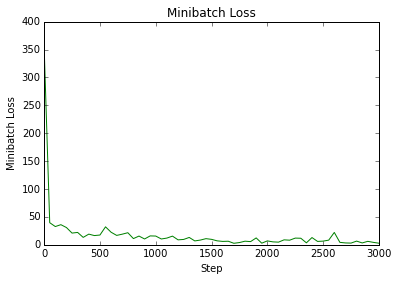

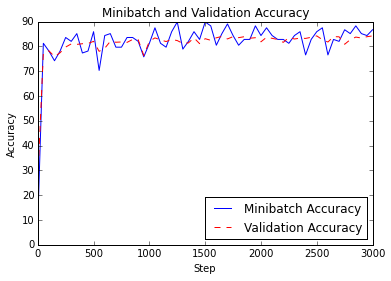

Wall time: 2min 20s


In [10]:
def train_sgd(batch_size, num_hidden_nodes, num_steps):
    graph = tf.Graph()
    with graph.as_default():      
      with tf.name_scope('input'): 
        tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size), name='train_dataset')
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='train_labels')
        tf_valid_dataset = tf.constant(valid_dataset, name='valid_dataset')
        tf_test_dataset = tf.constant(test_dataset, name='test_dataset')
     
      with tf.name_scope('layer'): 
        with tf.name_scope('weights1'):
          weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]), name='weights1')
        with tf.name_scope('biases1'):
          biases1 = tf.Variable(tf.zeros([num_hidden_nodes]), name='biases1')
        with tf.name_scope('weights2'):
          weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]), name='weights2')
        with tf.name_scope('biases2'):
          biases2 = tf.Variable(tf.zeros([num_labels]), name='biases2')

      # Training with SGD.
      # See https://www.tensorflow.org/api_docs/python/nn/  
      layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
      logits = tf.matmul(layer1_train, weights2) + biases2
        
      with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
        tf.summary.scalar('loss', loss)
        
      with tf.name_scope('train'):
        train_step = tf.train.GradientDescentOptimizer(0.2).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
      valid_prediction = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)
      layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
      test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)
    
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print('Initialized')
      minibatch_loss = []
      minibatch_acc = []
      validation_acc = []
      eval_every = 50
      print('Step    Minibatch Loss   Minibatch Accuracy %   Validation Accuracy %')
      for step in range(num_steps):   
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)   
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]   
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([train_step, loss, train_prediction], feed_dict=feed_dict)      
        if (step % eval_every == 0):
          minibatch_loss.append(l) 
          ma = accuracy(predictions, batch_labels)
          minibatch_acc.append(ma)
          va = accuracy(valid_prediction.eval(), valid_labels)
          validation_acc.append(va)
          if (step % 500 == 0):
            print("%-10d %-20.2f %-22.2f %-20.2f" % (step, l, ma, va))        
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
      steps = range(0, num_steps, eval_every)
      plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)  

%time train_sgd(128, 1024, 3001)